# CITS5017 Project 1
Kaylee Molin (22734429)

September 2023

---

### Importing Relevant Packages

In [21]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.utils import to_categorical # FIX ask if this is allowed
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier # for hyperparam tuning only
from tensorflow.keras.optimizers import SGD
import os, time


### Loading dataset

In [2]:
(X_train_original, y_train_original), (X_test_original, y_test_original) = tf.keras.datasets.cifar10.load_data()
assert X_train_original.shape == (50000, 32, 32, 3)
assert X_test_original.shape == (10000, 32, 32, 3)
assert y_train_original.shape == (50000, 1)
assert y_test_original.shape == (10000, 1)

### Normalising the pixel values to be between 0 and 1

In [3]:
X_train_norm, X_test = X_train_original/255.0, X_test_original/255.0
y_test=y_test_original
y_train = y_train_original

### (i) Forming a validation set form the training set

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train_norm, y_train, test_size=0.15, random_state=22, stratify=y_train_original)
# Print the shapes of the resulting datasets
print("Training set shapes:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("\nValidation set shapes:")
print("X_val:", X_val.shape)
print("y_val:", y_val.shape)
print("\nTest set shapes:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Training set shapes:
X_train: (42500, 32, 32, 3)
y_train: (42500, 1)

Validation set shapes:
X_val: (7500, 32, 32, 3)
y_val: (7500, 1)

Test set shapes:
X_test: (10000, 32, 32, 3)
y_test: (10000, 1)


### (ii) Function to display 20 randomly sampled images

In [5]:
def display_random_subset(X, y, class_names, title):
    plt.figure(figsize=(12, 6))
    indices = np.random.randint(0, len(X), size=20)
    
    for i, index in enumerate(indices):
        plt.subplot(4, 5, i+1)
        plt.imshow(X[index])
        plt.title(class_names[y[index][0]])
        plt.axis('off')
    
    plt.suptitle(title, fontsize=16)  # Adding a title to the entire figure
    plt.subplots_adjust(wspace=0.2, hspace=0.4)  # Adjusting the horizontal and vertical space
    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjusting layout for the title
    plt.show()


In [6]:
# Load class names from TFDS
dataset_info = tfds.builder("cifar10")
class_names = dataset_info.info.features["label"].names

2023-09-03 22:08:10.564602: W tensorflow/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


### Displaying 20 random images from the training set

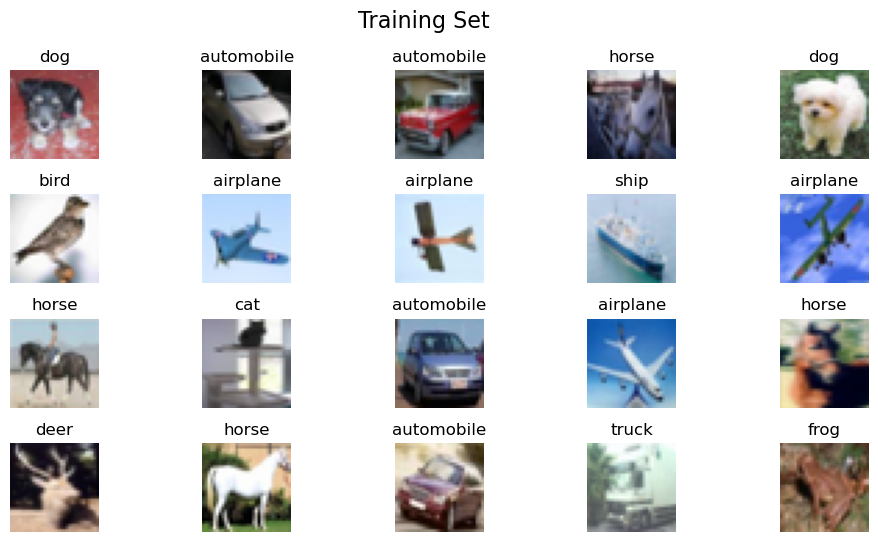

In [7]:
display_random_subset(X_train, y_train, class_names, "Training Set")

### Displaying 20 random images from the validation set

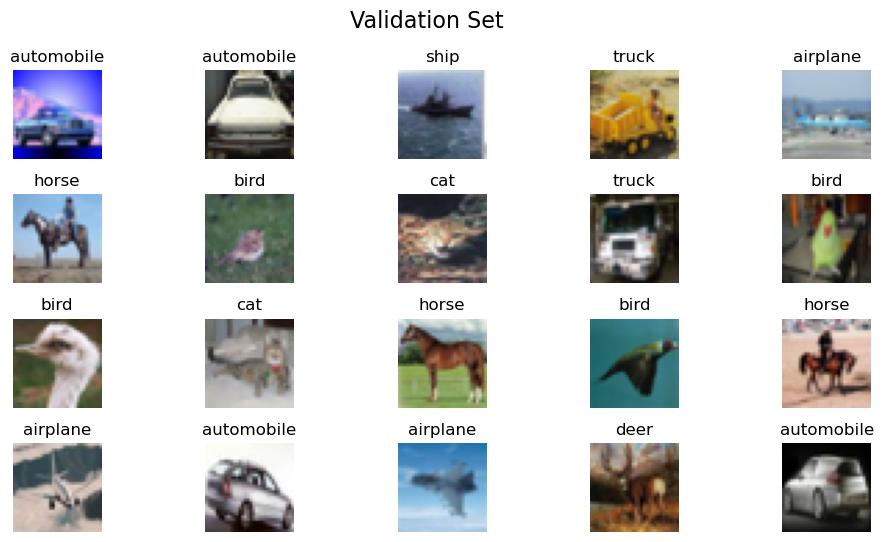

In [8]:
display_random_subset(X_val, y_val, class_names, "Validation Set")

### Displaying 20 random images from the testing set

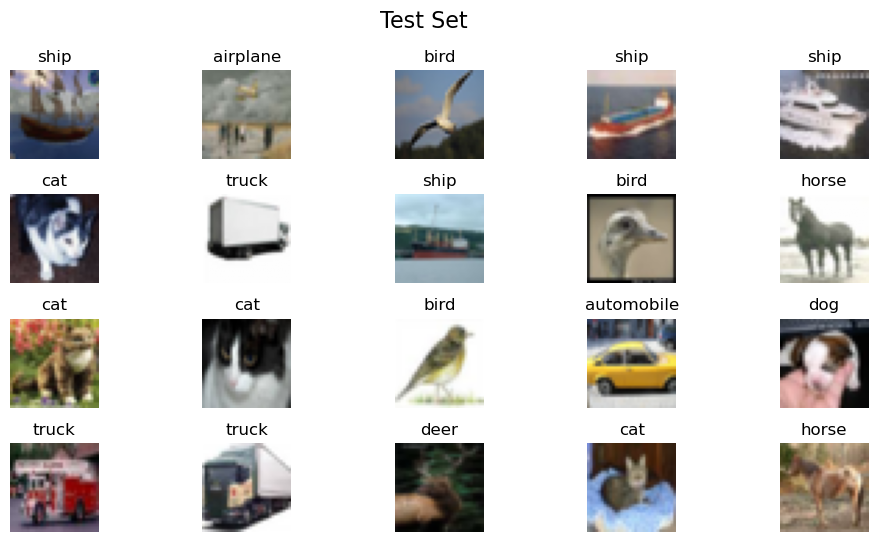

In [9]:
display_random_subset(X_test, y_test, class_names, "Test Set")

In [10]:
# ds, ds_info = tfds.load('cifar10', split='train', with_info=True)
# fig = tfds.show_examples(ds, ds_info)

In [11]:
# Get the number of classes
num_classes = len(class_names)

# y_train = to_categorical(y_train, num_classes)
# y_val = to_categorical(y_val, num_classes)
# y_test = to_categorical(y_test, num_classes)

In [12]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((42500, 32, 32, 3), (10000, 32, 32, 3), (42500, 1), (10000, 1))

### (iii) Training an MLP

I have decided to use 2 hidden layers...

In [13]:
# new architecture 02/09

def create_mlp_model(learning_rate=0.01, weight_initializer='glorot_uniform', dropout_rate=0):
    model = Sequential([
        Flatten(input_shape=[32, 32, 3]),
        Dense(512, activation='relu', kernel_initializer=weight_initializer),
        Dropout(dropout_rate),
        Dense(256, activation='relu', kernel_initializer=weight_initializer),
        Dropout(dropout_rate),
        Dense(10, activation='softmax')
    ])

    optimizer = SGD(learning_rate=learning_rate)
    # optimizer=tf.keras.optimizers.legacy.Adam()

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
weight_initializations = ['glorot_uniform', 'he_normal'] # read https://keras.io/api/layers/initializers/ for more initialisers
dropout_rates = [0, 0.2]
learning_rates = [0.01, 0.1]

# Lists to store results
results = []

for weight_init in weight_initializations:
    for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
            model = create_mlp_model(learning_rate=learning_rate, weight_initializer=weight_init, dropout_rate=dropout_rate)

            # Define early stopping callback
            early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

            # Train the model with early stopping on the validation set
            history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

            # Evaluate the model on the test set
            test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

            # Print results for each combination of hyperparameters
            print(f"Weight Init: {weight_init}, Dropout Rate: {dropout_rate}, Learning Rate: {learning_rate}")
            print("Test loss:", test_loss)
            print("Test accuracy:", test_accuracy)
            print("-" * 40)

            # Store results
            results.append({
                'Weight Init': weight_init,
                'Learning Rate': learning_rate,
                'Dropout Rate': dropout_rate,
                'Test Accuracy': test_accuracy
            })

# Print results
for result in results:
    print("Weight Init:", result['Weight Init'])
    print("Learning Rate:", result['Learning Rate'])
    print("Dropout Rate:", result['Dropout Rate'])
    print("Test Accuracy:", result['Test Accuracy'])


2023-09-03 22:08:17.706588: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-09-03 22:08:17.706611: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-09-03 22:08:17.706618: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-09-03 22:08:17.706654: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-03 22:08:17.706675: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/100
   1/1329 [..............................] - ETA: 7:56 - loss: 2.7717 - accuracy: 0.0938

2023-09-03 22:08:18.769106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: 1.9748 - accuracy: 0.2912

2023-09-03 22:08:28.515994: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 11s 8ms/step - loss: 1.9748 - accuracy: 0.2912 - val_loss: 3.2187 - val_accuracy: 0.1291
Epoch 2/100
1329/1329 [==============================] - 10s 8ms/step - loss: 1.8816 - accuracy: 0.3338 - val_loss: 2.1530 - val_accuracy: 0.2637
Epoch 3/100
1329/1329 [==============================] - 10s 8ms/step - loss: 2.0479 - accuracy: 0.3064 - val_loss: 3.4313 - val_accuracy: 0.1651
Epoch 4/100
1329/1329 [==============================] - 10s 8ms/step - loss: 2.7336 - accuracy: 0.2629 - val_loss: 7.1242 - val_accuracy: 0.1821
Epoch 5/100
1329/1329 [==============================] - 10s 8ms/step - loss: 3.6169 - accuracy: 0.2486 - val_loss: 9.9480 - val_accuracy: 0.1669
Epoch 6/100
1329/1329 [==============================] - 10s 8ms/step - loss: 4.6423 - accuracy: 0.2320 - val_loss: 17.6675 - val_accuracy: 0.1552
Epoch 7/100
1329/1329 [==============================] - 10s 8ms/step - loss: 5.9765 - accuracy: 0.2260 - val_loss: 10.4146 - val_accur

Weight Init: glorot_uniform, Dropout Rate: 0, Learning Rate: 0.01
Test loss: 2.1505348682403564
Test accuracy: 0.25929999351501465
----------------------------------------
Epoch 1/100
   8/1329 [..............................] - ETA: 10s - loss: 821676480.0000 - accuracy: 0.0781

2023-09-03 22:10:27.878065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0999

2023-09-03 22:10:37.579155: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 11s 8ms/step - loss: nan - accuracy: 0.0999 - val_loss: nan - val_accuracy: 0.1000
Epoch 2/100
1329/1329 [==============================] - 10s 8ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 3/100
1329/1329 [==============================] - 10s 8ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 4/100
1329/1329 [==============================] - 10s 8ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 5/100
1329/1329 [==============================] - 10s 8ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 6/100
1329/1329 [==============================] - 10s 8ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 7/100
1329/1329 [==============================] - 10s 8ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 8/100
1329/1329 [=========

Epoch 1/100
   1/1329 [..............................] - ETA: 7:26 - loss: 3.0869 - accuracy: 0.2188

2023-09-03 22:12:14.221310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: 2.0693 - accuracy: 0.2618

2023-09-03 22:12:25.833546: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 13s 9ms/step - loss: 2.0693 - accuracy: 0.2618 - val_loss: 1.9144 - val_accuracy: 0.3289
Epoch 2/100
1329/1329 [==============================] - 12s 9ms/step - loss: 1.9328 - accuracy: 0.3149 - val_loss: 2.4924 - val_accuracy: 0.1851
Epoch 3/100
1329/1329 [==============================] - 12s 9ms/step - loss: 1.9383 - accuracy: 0.3200 - val_loss: 2.0338 - val_accuracy: 0.3117
Epoch 4/100
1329/1329 [==============================] - 12s 9ms/step - loss: 2.0974 - accuracy: 0.2953 - val_loss: 4.2716 - val_accuracy: 0.1933
Epoch 5/100
1329/1329 [==============================] - 13s 10ms/step - loss: 2.5346 - accuracy: 0.2618 - val_loss: 4.2323 - val_accuracy: 0.1789
Epoch 6/100
1329/1329 [==============================] - 12s 9ms/step - loss: 3.0966 - accuracy: 0.2476 - val_loss: 8.5035 - val_accuracy: 0.1408
Epoch 7/100
1329/1329 [==============================] - 13s 10ms/step - loss: 3.7498 - accuracy: 0.2366 - val_loss: 10.1008 - val_accu

Epoch 1/100


2023-09-03 22:14:38.597063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: nan - accuracy: 0.1000

2023-09-03 22:14:50.164293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 13s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 2/100
1329/1329 [==============================] - 12s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 3/100
1329/1329 [==============================] - 12s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 4/100
1329/1329 [==============================] - 14s 11ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 5/100
1329/1329 [==============================] - 12s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 6/100
1329/1329 [==============================] - 11s 8ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 7/100
1329/1329 [==============================] - 12s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 8/100
1329/1329 [========

Epoch 1/100
   7/1329 [..............................] - ETA: 11s - loss: 2.9234 - accuracy: 0.1205 

2023-09-03 22:16:44.757921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: 1.9852 - accuracy: 0.2898

2023-09-03 22:16:54.547689: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 11s 8ms/step - loss: 1.9852 - accuracy: 0.2898 - val_loss: 2.2268 - val_accuracy: 0.2460
Epoch 2/100
1329/1329 [==============================] - 10s 8ms/step - loss: 1.9242 - accuracy: 0.3218 - val_loss: 2.9183 - val_accuracy: 0.2112
Epoch 3/100
1329/1329 [==============================] - 11s 8ms/step - loss: 2.2827 - accuracy: 0.2867 - val_loss: 3.8819 - val_accuracy: 0.2163
Epoch 4/100
1329/1329 [==============================] - 10s 8ms/step - loss: 3.2526 - accuracy: 0.2446 - val_loss: 9.7022 - val_accuracy: 0.1491
Epoch 5/100
1329/1329 [==============================] - 10s 8ms/step - loss: 4.3078 - accuracy: 0.2310 - val_loss: 14.7420 - val_accuracy: 0.1607
Epoch 6/100
1329/1329 [==============================] - 11s 8ms/step - loss: 5.7697 - accuracy: 0.2273 - val_loss: 15.1138 - val_accuracy: 0.1308
Epoch 7/100
1329/1329 [==============================] - 12s 9ms/step - loss: 7.3406 - accuracy: 0.2231 - val_loss: 19.5281 - val_accu

Weight Init: he_normal, Dropout Rate: 0, Learning Rate: 0.01
Test loss: 2.233855724334717
Test accuracy: 0.24549999833106995
----------------------------------------


Epoch 1/100
   1/1329 [..............................] - ETA: 8:23 - loss: 2.9806 - accuracy: 0.0312

2023-09-03 22:18:46.902810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: nan - accuracy: 0.1000

2023-09-03 22:18:57.547061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 12s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 2/100
1329/1329 [==============================] - 13s 10ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 3/100
1329/1329 [==============================] - 11s 8ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 4/100
1329/1329 [==============================] - 10s 8ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 5/100
1329/1329 [==============================] - 10s 8ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 6/100
1329/1329 [==============================] - 10s 7ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 7/100
1329/1329 [==============================] - 10s 7ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 8/100
1329/1329 [========

Weight Init: he_normal, Dropout Rate: 0, Learning Rate: 0.1
Test loss: nan
Test accuracy: 0.10000000149011612
----------------------------------------
Epoch 1/100
   1/1329 [..............................] - ETA: 7:18 - loss: 3.2452 - accuracy: 0.1562

2023-09-03 22:20:39.213696: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: 2.1249 - accuracy: 0.2612

2023-09-03 22:20:50.624859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 13s 9ms/step - loss: 2.1249 - accuracy: 0.2612 - val_loss: 2.5656 - val_accuracy: 0.2088
Epoch 2/100
1329/1329 [==============================] - 12s 9ms/step - loss: 1.9632 - accuracy: 0.3070 - val_loss: 2.7195 - val_accuracy: 0.1767
Epoch 3/100
1329/1329 [==============================] - 12s 9ms/step - loss: 1.9391 - accuracy: 0.3160 - val_loss: 2.3595 - val_accuracy: 0.2252
Epoch 4/100
1329/1329 [==============================] - 11s 9ms/step - loss: 1.9620 - accuracy: 0.3158 - val_loss: 2.7822 - val_accuracy: 0.1900
Epoch 5/100
1329/1329 [==============================] - 12s 9ms/step - loss: 2.1283 - accuracy: 0.2900 - val_loss: 3.6660 - val_accuracy: 0.2141
Epoch 6/100
1329/1329 [==============================] - 12s 9ms/step - loss: 2.4610 - accuracy: 0.2667 - val_loss: 4.1071 - val_accuracy: 0.1975
Epoch 7/100
1329/1329 [==============================] - 12s 9ms/step - loss: 2.9808 - accuracy: 0.2510 - val_loss: 4.0342 - val_accurac

Weight Init: he_normal, Dropout Rate: 0.2, Learning Rate: 0.01
Test loss: 2.3864293098449707
Test accuracy: 0.21940000355243683
----------------------------------------
Epoch 1/100
   1/1329 [..............................] - ETA: 7:33 - loss: 3.0339 - accuracy: 0.1875

2023-09-03 22:23:13.508770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0999

2023-09-03 22:23:24.565290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 12s 9ms/step - loss: nan - accuracy: 0.0999 - val_loss: nan - val_accuracy: 0.1000
Epoch 2/100
1329/1329 [==============================] - 12s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 3/100
1329/1329 [==============================] - 12s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 4/100
1329/1329 [==============================] - 12s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 5/100
1329/1329 [==============================] - 11s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 6/100
1329/1329 [==============================] - 12s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 7/100
1329/1329 [==============================] - 11s 9ms/step - loss: nan - accuracy: 0.1000 - val_loss: nan - val_accuracy: 0.1000
Epoch 8/100
1329/1329 [=========

> The combination of hyperameters that resulted int he highest accuracy are:

Weight Init: glorot_uniform
Dropout Rate: 0.2
Learning Rate: 0.01
Using the SGD optimiser.

The resulting validation accuracy is: 0.527
THe resulting validation loss is: 1.324

In [22]:
model_filename = 'Molin_Kaylee-MLP'

try:
    # Try to load the model
    model_mlp = tf.keras.models.load_model(model_filename)
    model_mlp.summary()
    history_mlp = model_mlp.fit(X_train, y_train, epochs = 1, validation_data = (X_val, y_val), callbacks = [early_stopping])

except OSError:
    # Model file does not exist, create and train a new model
    print("Cannot find an existing MLP model in the current directory. Creating and training a new model.")
    model_mlp = create_mlp_model(learning_rate=0.01, weight_initializer='glorot_uniform', dropout_rate=0.2)
    model_mlp.summary()
    
    mlp_start = time.time()
    history_mlp = model_mlp.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])
    mlp_end = time.time()
    
    # Save the trained model
    model_mlp.save(model_filename)

Cannot find an existing MLP model in the current directory. Creating and training a new model.
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 3072)              0         
                                                                 
 dense_30 (Dense)            (None, 512)               1573376   
                                                                 
 dropout_20 (Dropout)        (None, 512)               0         
                                                                 
 dense_31 (Dense)            (None, 256)               131328    
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 dense_32 (Dense)            (None, 10)                2570      
                        

2023-09-03 22:47:23.895284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - ETA: 0s - loss: 2.0669 - accuracy: 0.2624

2023-09-03 22:47:35.379111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1329/1329 [==============================] - 13s 9ms/step - loss: 2.0669 - accuracy: 0.2624 - val_loss: 2.1091 - val_accuracy: 0.2548
Epoch 2/100
1329/1329 [==============================] - 14s 10ms/step - loss: 1.9304 - accuracy: 0.3161 - val_loss: 2.0463 - val_accuracy: 0.2757
Epoch 3/100
1329/1329 [==============================] - 12s 9ms/step - loss: 1.9344 - accuracy: 0.3204 - val_loss: 2.4346 - val_accuracy: 0.2449
Epoch 4/100
1329/1329 [==============================] - 13s 10ms/step - loss: 2.0676 - accuracy: 0.3006 - val_loss: 4.6306 - val_accuracy: 0.1553
Epoch 5/100
1329/1329 [==============================] - 13s 9ms/step - loss: 2.3774 - accuracy: 0.2742 - val_loss: 5.3475 - val_accuracy: 0.1391
Epoch 6/100
1329/1329 [==============================] - 13s 9ms/step - loss: 2.9303 - accuracy: 0.2495 - val_loss: 7.4287 - val_accuracy: 0.1355
Epoch 7/100
1329/1329 [==============================] - 12s 9ms/step - loss: 3.8775 - accuracy: 0.2349 - val_loss: 6.4262 - val_accur

INFO:tensorflow:Assets written to: Molin_Kaylee-MLP/assets


In [23]:
model_mlp.evaluate(X_test, y_test)


313/313 [==============================] - 2s 6ms/step - loss: 2.0571 - accuracy: 0.2737


[2.057077407836914, 0.2736999988555908]

In [ ]:
# mlp_model = KerasClassifier(build_fn=create_mlp_model)
# mlp_param = dict(kernel_initializer=['he_uniform','glorot_uniform'],
#                 learning_rate=[0.01,0.1],
#                 dropout_rate = [0.2, 0.3])

# mlp_grid = GridSearchCV(estimator=mlp_model, param_grid=mlp_param, n_jobs=-1,cv=3)
# grid_result = mlp_grid.fit(X_val,y_val,epochs=100)
# grid_result.best_params_

In [ ]:
# # Get the number of classes
# # num_classes = len(class_names)

# # Create the MLP model
# model_mlp = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=[32, 32, 3]),
#     #tf.keras.layers.Dense(1024, activation='relu'),  
#     tf.keras.layers.Dense(1024, activation='relu', kernel_initializer='he_normal'),
#     Dropout(0.2),  # Use the dropout_rate parameter here
#     # tf.keras.layers.Dense(1000, activation='relu'),   
#     tf.keras.layers.Dense(512, activation='relu', kernel_initializer='he_normal'),
#     Dropout(0.2),  # Use the dropout_rate parameter here
#     tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer with num_classes units and softmax activation
# ])

# optimizer=tf.keras.optimizers.legacy.Adam()
# #optimizer = SGD(learning_rate=0.1)

# # Compile the model
# model_mlp.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Defining the early stopping callback
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# history = model_mlp.fit(X_train, y_train, epochs=100,batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_cb])

# model_mlp.summary()


### https://github.com/adameksopot/MLP-for-Cifar10-/blob/master/MLP.ipynb
### try this! very good accuracy

In [ ]:
# # Hyperparameters to experiment with
# weight_initializations = ['glorot_uniform', 'he_normal'] # read https://keras.io/api/layers/initializers/ for more initialisers
# dropout_rates = [0.2, 0.4]
# input_shape=(32, 32, 3)

# for weight_init in weight_initializations:
#     for dropout_rate in dropout_rates:

#         print("Weight initialisation: {}".format(weight_init))
#         print("Dropout rate: {}".format(dropout_rate))
#         # Create the MLP model with hyperparameters
#         model = Sequential([
#             Flatten(input_shape=input_shape),
#             Dense(512, activation='relu', kernel_initializer=weight_init),
#             Dropout(dropout_rate),
#             Dense(256, activation='relu', kernel_initializer=weight_init),
#             Dropout(dropout_rate),
#             Dense(num_classes, activation='softmax')
#         ])

#         # Compile the model
#         model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#                         loss='sparse_categorical_crossentropy',
#                         metrics=['accuracy'])

#         # Define early stopping callback
#         early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#         # Train the model with early stopping on the validation set
#         history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[early_stopping])

#         # Evaluate the model on the test set
#         test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
        
#         # Print results for each combination of hyperparameters
#         print(f"Weight Init: {weight_init}, Dropout Rate: {dropout_rate}")
#         print("Test accuracy:", test_accuracy)
#         print("-" * 40)

## CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

num_classes = 10
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
batch_size = 64
epochs = 10
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=2)
print("\nTest accuracy:", test_accuracy)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization

num_classes = 10

# Define hyperparameter values to explore
kernel_sizes = [(3, 3), (5, 5)]
num_kernels = [32, 64]
activation_functions = ['relu', 'tanh']

# Lists to store results
results = []

# Iterate through all combinations
for kernel_size in kernel_sizes:
    for num_kernel in num_kernels:
        for activation_function in activation_functions:
            model = Sequential()
            model.add(Conv2D(num_kernel, kernel_size, activation=activation_function, input_shape=(32, 32, 3)))
            model.add(MaxPooling2D((2, 2)))
            model.add(BatchNormalization())
            model.add(Conv2D(num_kernel * 2, kernel_size, activation=activation_function))
            model.add(MaxPooling2D((2, 2)))
            model.add(Conv2D(num_kernel * 4, kernel_size, activation=activation_function))
            model.add(MaxPooling2D((2, 2)))
            model.add(Flatten())
            model.add(Dense(128, activation=activation_function))
            model.add(BatchNormalization())
            model.add(Dense(64, activation=activation_function))
            model.add(Dense(num_classes, activation='softmax'))

            print("---")
            print("num_kernal: {}, activation_function: {}, kernel_size: {}".format{num_kernel, activation_function, kernel_size})

            # Compile the model
            model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

            # Train the model
            batch_size = 64
            epochs = 30
            history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), verbose=1)

            # Evaluate the model
            test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=0)

            # Store results
            results.append({
                'Kernel Size': kernel_size,
                'Number of Kernels': num_kernel,
                'Activation Function': activation_function,
                'Test Accuracy': test_accuracy
            })

# Print results
for result in results:
    print("Kernel Size:", result['Kernel Size'])
    print("Number of Kernels:", result['Number of Kernels'])
    print("Activation Function:", result['Activation Function'])
    print("Test Accuracy:", result['Test Accuracy'])
   
